# Imports

In [1]:
import argparse
import os
import sys
sys.path.append("../")
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"

In [2]:
import glob
import albumentations
import pandas as pd
import zeus
import torch
import torch.nn as nn
from pathlib import Path
from efficientnet_pytorch import EfficientNet
from sklearn import metrics, model_selection, preprocessing
from zeus.callbacks import EarlyStopping, TensorBoardLogger, GradientClipping, PlotLoss
from zeus.metrics import LabelSmoothingCrossEntropy
from zeus.datasets import ImageDataset
from torch.nn import functional as F

In [3]:
from zeus.utils.model_helpers import *

In [4]:
from PIL import Image
from torch.utils.data import Dataset

# Defining

## Params

In [5]:
INPUT_PATH = "/media/hdd/Datasets/CamVid/"
MODEL_PATH = "./models/"
MODEL_NAME = os.path.basename("seg.pt")
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 140
# IMAGE_SIZE = 192

In [6]:
map_path = INPUT_PATH+"class_dict.csv"
map_dict = pd.read_csv(map_path); map_dict.head(1)
map_dict["name"].nunique()

32

## Label the data

In [8]:
class CamvidDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_L.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
#         mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
#         mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        return {"image":image, "targets":mask.clone().detach()}

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [10]:
from os.path import isfile, join
from zeus.metrics import dice

# class BCELoss2d(nn.Module):
#     """
#     Code taken from:
#     https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37208
#     """

#     def __init__(self, weight=None, size_average=True):
#         super(BCELoss2d, self).__init__()
#         self.bce_loss = nn.BCELoss(weight, size_average)

#     def forward(self, logits, targets):
#         probs = F.sigmoid(logits)
#         probs_flat = probs.view(-1)
#         targets_flat = targets.view(-1)
#         return self.bce_loss(probs_flat, targets_flat)

class Model(zeus.Model):
    def __init__(self, n_classes):
        super().__init__()

        self.model = UNET(3, n_classes).cuda()

#     def monitor_metrics(self, outputs, targets):
# #         accuracy = dice(targets, outputs)
# #         return {"dice_score": float(accuracy)}
#         return {"dice_score": 0.0}
    def monitor_metrics(self,outloss):
        return {"epoch" : self.current_epoch, "ce_loss":float(outloss)}

    def fetch_optimizer(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return opt

    def forward(self, image, targets=None):
        batch_size, _, _, _ = image.shape
        outputs = self.model(image)

        if targets is not None:
            targets = targets.long()
            targets = torch.argmax(targets, dim=3).long()
#             print(outputs.shape, targets.shape)
#             targets = targets.float().unsqueeze(1)
#             loss = nn.BCEWithLogitsLoss()(outputs, targets)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            metrics = self.monitor_metrics(loss)
            return outputs, loss, metrics
        return outputs, 0, {}

In [11]:
from albumentations.pytorch import ToTensorV2
train_aug = albumentations.Compose(
    [
        albumentations.Resize(160,240),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
        ToTensorV2(),
    ],
    p=1.0,
)

valid_aug = albumentations.Compose(
    [
        albumentations.Resize(160,240),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
        ToTensorV2(),
    ],
    p=1.0,
)

## Data pre process

## Training

In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader
train_ds = CamvidDataset(
        image_dir="/media/hdd/Datasets/CamVid/train/",
        mask_dir="/media/hdd/Datasets/CamVid/train_labels/",
        transform=train_aug,
    )
valid_ds = CamvidDataset(
        image_dir="/media/hdd/Datasets/CamVid/val/",
        mask_dir="/media/hdd/Datasets/CamVid/val_labels/",
        transform=valid_aug,
    )

## Callbacks

In [13]:
model = Model(32)

es = EarlyStopping(
    monitor="valid_loss",
    model_path=os.path.join(MODEL_PATH, MODEL_NAME + ".bin"),
    patience=3,
    mode="min",
)

tb = TensorBoardLogger()
grc = GradientClipping(5)
pl = PlotLoss(10)

In [14]:
count_parameters(model, showtable=False)

Total Trainable Params: 31039648


31039648

100%|███████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.03it/s, ce_loss=1.03, epoch=9, loss=1.03, stage=valid]


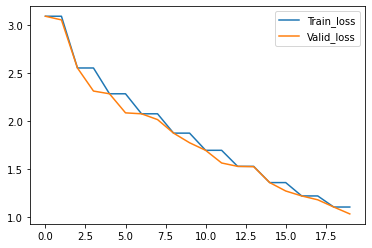

100%|████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.43it/s, ce_loss=0.363, epoch=19, loss=0.363, stage=valid]


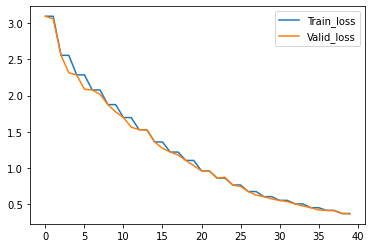

100%|████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.19it/s, ce_loss=0.225, epoch=29, loss=0.225, stage=valid]


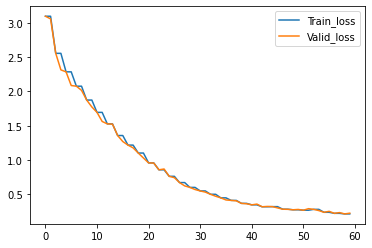

In [21]:
EPOCHS = 30

model.fit(
    train_ds,
    valid_dataset=valid_ds,
    train_bs=TRAIN_BATCH_SIZE,
    valid_bs=TRAIN_BATCH_SIZE,
    device="cuda",
    epochs=EPOCHS,
    callbacks=[grc, pl, tb],
    fp16=False,
)

In [27]:
model.save(Path(MODEL_PATH)/MODEL_NAME)

# Preds

In [15]:
mod = model.load(Path(MODEL_PATH)/MODEL_NAME)

In [16]:
tes =np.array(Image.open("/media/hdd/Datasets/CamVid/val/0001TP_009030.png"))
tes = torch.tensor(tes).unsqueeze(0)
tes = torch.einsum('bhwc->bchw',tes)
tes.shape

torch.Size([1, 3, 720, 960])

In [17]:
mo = model.model
mo.eval()
test_output = mo(tes.float().cuda())

In [32]:
test_output = torch.einsum('bchw->hwc',test_output)
test_output.shape

torch.Size([720, 960, 32])

In [33]:
tes_np = np.array(test_output.detach().cpu())

In [34]:
tes_np.shape

(720, 960, 32)

In [42]:
tes_np[:,:,1]

array([[-5.588546 , -7.94691  , -6.858595 , ..., -6.415303 , -5.9916525,
        -0.7351766],
       [-7.8356924, -8.306384 , -5.2875543, ..., -4.8197813,  4.188528 ,
         4.1299067],
       [-8.229677 , -8.994326 , -4.9207425, ..., -2.2999282, 11.444969 ,
         6.1160836],
       ...,
       [-1.6127683, -1.6017292, -1.6460749, ..., -2.8616595, -2.2277963,
        -2.186717 ],
       [-1.4812593, -1.6607118, -1.5190713, ..., -2.6110816, -1.1935558,
        -1.348736 ],
       [-1.2042295, -1.1900505, -1.3941761, ..., -2.19895  , -1.4170023,
        -1.6202601]], dtype=float32)

In [154]:
im = pil_from_tensor(test_output[:,:,1])
im = np.array(im.convert("RGB"))


# Testing imae encodings

In [201]:
map_dict["name"] = map_dict["name"].astype("category")

map_dict["label"]=map_dict["name"].cat.codes
map_dict["value"] = map_dict[["r","g","b"]].values.tolist()

ts = "/media/hdd/Datasets/CamVid/test_labels/0001TP_006690_L.png"

In [202]:
test_im = np.array(Image.open(ts))

In [205]:
# test_label = map_dict.head(100) 
test_label = map_dict[["value","label"]]; test_label.head()

,value,label
0,"[64, 128, 64]",0
1,"[192, 0, 128]",1
2,"[0, 128, 192]",2
3,"[0, 128, 64]",3
4,"[128, 0, 0]",4


In [211]:
mapping_f = {str(x["value"]).replace(",",''):x["label"] for x in test_label.to_dict(orient="records")}

In [215]:
str(test_im[0,0,:])

'[128   0   0]'

In [213]:
mapping_f[str(test_im[0,0,:]).replace("  ","")]

4

In [195]:
mapping_f

{'[64 128 64]': 0,
 '[192 0 128]': 1,
 '[0 128 192]': 2,
 '[0 128 64]': 3,
 '[128 0 0]': 4,
 '[64 0 128]': 5,
 '[64 0 192]': 6,
 '[192 128 64]': 7,
 '[192 192 128]': 8,
 '[64 64 128]': 9,
 '[128 0 192]': 10,
 '[192 0 64]': 11,
 '[128 128 64]': 12,
 '[192 0 192]': 13,
 '[128 64 64]': 14,
 '[64 192 128]': 15,
 '[64 64 0]': 16,
 '[128 64 128]': 17,
 '[128 128 192]': 18,
 '[0 0 192]': 20,
 '[192 128 128]': 21,
 '[128 128 128]': 22,
 '[64 128 192]': 19,
 '[0 0 64]': 23,
 '[0 64 64]': 24,
 '[192 64 128]': 25,
 '[128 128 0]': 26,
 '[192 128 192]': 27,
 '[64 0 64]': 28,
 '[192 192 0]': 29,
 '[0 0 0]': 30,
 '[64 192 0]': 31}